# State Distribution Example

In this example, we plan to plot the distribution of system states. This helps researchers on serverless computing platforms to debug and test out their performance models with knowledge of system state distribution.

In [1]:
# imports

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from pacssim.ServerlessSimulator import ServerlessSimulator as Sim

sim = Sim(arrival_rate=0.9, warm_service_rate=1/1.991, cold_service_rate=1/2.244,
            expiration_threshold=600, max_time=1e6)
sim.generate_trace(debug_print=False)
sim.print_trace_results()

Cold Starts / total requests: 	 1150 / 898419
Cold Start Probability: 	 0.0013
Rejection / total requests: 	 0 / 898419
Rejection Probability: 		 0.0000
Average Instance Life Span: 	 6677.0074
Average Server Count:  		 7.6729
Average Running Count:  	 1.7886
Average Idle Count:  		 5.8843


You can define any state representation you want based on the data present in the trace.
Here, we chose to use the number of servers as state.

In [8]:
sim.calculate_time_lengths()

# encode states
hist_states = []
for idx in range(len(sim.hist_server_count)):
    if sim.hist_server_count[idx] == 0:
        hist_states.append((0, 'd'))
    else:
        curr_server_count = sim.hist_server_count[idx]
        prev_server_count = sim.hist_server_count[idx-1]
        if curr_server_count > prev_server_count:
            hist_states.append((curr_server_count, 'u'))
        elif curr_server_count < prev_server_count:
            hist_states.append((curr_server_count, 'd'))
        else: # state hasn't changed
            hist_states.append(hist_states[-1])

vals, probs = sim.calculate_time_average(hist_states, skip_init_time=100)
sim.print_time_average(vals, probs)
residence_time_avgs = sim.get_average_residence_times(hist_states, skip_init_time=100)
residence_time_list = [residence_time_avgs[s] for s in vals]
df = pd.DataFrame(data = {'state': vals, 'prob': probs, 'sojourn_time': residence_time_list})
df = df.sort_values(by='state')
df

Value           Prob
(7, 'd')        0.2938
(12, 'u')       0.0006
(9, 'u')        0.1208
(9, 'd')        0.0026
(7, 'u')        0.1072
(8, 'u')        0.3413
(6, 'u')        0.0001
(8, 'd')        0.0507
(6, 'd')        0.0554
(5, 'd')        0.0001
(11, 'u')       0.0042
(11, 'd')       0.0000
(10, 'd')       0.0000
(10, 'u')       0.0234


,state,prob,sojourn_time
9,"(5, d)",6.754917e-05,67.542439
8,"(6, d)",5.538324e-02,220.628375
6,"(6, u)",8.366666e-05,41.829162
0,"(7, d)",2.937783e-01,484.734372
4,"(7, u)",1.071500e-01,419.812134
7,"(8, d)",5.065592e-02,221.182850
5,"(8, u)",3.413182e-01,563.175292
3,"(9, d)",2.556210e-03,54.382042
2,"(9, u)",1.207662e-01,527.310838
12,"(10, d)",6.023376e-06,0.752847


## Calculate Average Transition Times

In [4]:
residence_times, transition_times = sim.analyze_custom_states(hist_states, skip_init_time=100)
transition_counts = {}
for k in transition_times:
    transition_counts[k] = len(transition_times[k])

t_starts = [s[0] for s in transition_counts.keys()]
t_ends = [s[1] for s in transition_counts.keys()]
t_counts = [transition_counts[k] for k in transition_counts.keys()]
t_avgs = [np.mean(transition_times[s]) for s in transition_counts.keys()]

df = pd.DataFrame(data = {'start': t_starts, 'end': t_ends, 'count': t_counts, 'average': t_avgs})

t_totals = [df.loc[df['start'] == k[0], 'count'].sum() for k in transition_counts.keys()]
df['totals'] = t_totals
df['prob'] = df['count'] / df['totals']

df = df.sort_values(by='start')
df

,start,end,count,average,totals,prob
21,"(5, d)","(6, u)",1,67.542439,1,1.000000
20,"(6, d)","(5, d)",1,121.857811,251,0.003984
4,"(6, d)","(7, u)",250,221.023457,251,0.996016
0,"(6, u)","(7, u)",2,41.829162,2,1.000000
5,"(7, d)","(8, u)",378,543.366043,606,0.623762
3,"(7, d)","(6, d)",228,387.529234,606,0.376238
1,"(7, u)","(8, u)",228,362.283815,251,0.908367
18,"(7, u)","(6, d)",23,990.092869,251,0.091633
8,"(8, d)","(7, d)",220,218.603919,229,0.960699
19,"(8, d)","(9, u)",9,284.223397,229,0.039301


## Calculate Transition Time Histograms

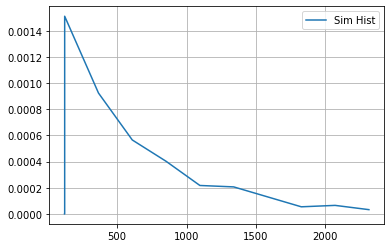

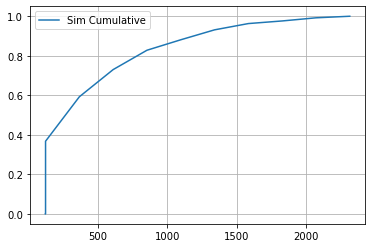

In [5]:
from pacssim.Utility import convert_hist_pdf

transition = ((7, 'd'),(8, 'u'))
traces = transition_times[transition]
num_bins = 10
base, hist_values, cumulative = convert_hist_pdf(traces, num_bins)

plt.figure()
plt.plot(base, hist_values, label='Sim Hist')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(base, cumulative, label='Sim Cumulative')
plt.legend()
plt.grid(True)

## Calculate Time Average of Server Count

Value           Prob
5               0.0001
6               0.0555
7               0.4009
8               0.3920
9               0.1233
10              0.0234
11              0.0042
12              0.0006


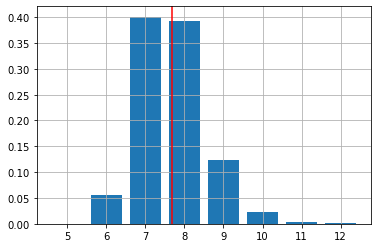

In [6]:
sim.calculate_time_lengths()

unq_vals, val_times = sim.calculate_time_average(sim.hist_server_count, skip_init_time=100)

plt.bar(unq_vals, val_times)
plt.grid(True)
plt.axvline(x=sim.get_average_server_count(), c='r')

sim.print_time_average(unq_vals, val_times)

In [7]:
pd.DataFrame(data = {'server_count': unq_vals, 'Probability': val_times}).sort_values('server_count')

,server_count,Probability
0,5,0.000068
1,6,0.055467
2,7,0.400928
3,8,0.391974
4,9,0.123322
5,10,0.023437
6,11,0.004203
7,12,0.000600
